In [15]:
import cv2
from pynq import allocate, Overlay
import numpy as np
import time
%matplotlib inline

init_time = time.time()

resize_design = Overlay("design_1.bit")

dma0 = resize_design.axi_dma_0 # input: image 
dma1 = resize_design.axi_dma_4 # output: class id 
dma2 = resize_design.axi_dma_3 # output: labelled image 
#dma3 = resize_design.axi_dma_3 # input: font input 
dma4 = resize_design.axi_dma_1 # font input 
#dma5 = resize_design.axi_dma_5 # word output
dma6 = resize_design.axi_dma_2 # input: image 
resizer   = resize_design.resize_accel_0 # resize 
alpha_mix = resize_design.wgen_mix_0  # mix label name and input image 
wgen      = resize_design.wgen_0    # generate image of label name 
#stream24x2= resize_design.stream24x2_0 
print("done bitsream loading")
print("init: %s seconds " % (time.time()-init_time))

done bitsream loading
init: 5.661370754241943 seconds 


In [16]:
global_font_cached = 0

def run_kernel():
    dma0.sendchannel.transfer(in_buffer)
    dma6.sendchannel.transfer(in_buffer)
    dma1.recvchannel.transfer(out_buffer)
    dma2.recvchannel.transfer(out_buffer2)
#    dma3.sendchannel.transfer(font)
    global global_font_cached
    if 0 == global_font_cached:
        dma4.sendchannel.transfer(font)
    #dma5.recvchannel.transfer(wimg)
    wgen.write(0x10,font_w)
    wgen.write(0x18,font_h)
    wgen.write(0x20,font_n)
#     print("ol status %d"% (resizer.read(0x00)))
    resizer.write(0x00,0x81) # start
    alpha_mix.write(0x00,0x81) # start
    wgen.write(0x00,0x81)
#     print("ol status %d"% (resizer.read(0x00)))
    dma0.sendchannel.wait()
    dma6.sendchannel.wait()
    dma1.recvchannel.wait()
    dma2.recvchannel.wait()
    if 0 == global_font_cached:
        global_font_cached = 1
        dma4.sendchannel.wait()
    #dma5.recvchannel.wait()
    #h3.sendchannel.wait()

In [17]:
from PIL import Image
# load font image
font_h=32
font_w=23
font_n=36
font_c=4 # font channel
word_l=9
word_c=3
fimg = Image.open('font_256.png')
fbuf = np.array(fimg)
font = allocate(shape=(font_h, font_w * font_n, font_c), dtype=np.uint8, cacheable=1)
font[:]=fbuf
wimg = allocate(shape=(font_h, font_w * word_l, word_c), dtype=np.uint8, cacheable=1)

In [18]:
old_width, old_height = 960,540
in_buffer = allocate(shape=(old_height, old_width, 3),
                                   dtype=np.uint8, cacheable=1)
# output: class id
out_buffer = allocate(shape=(1,),
                            dtype=np.uint8, cacheable=1)
# output: labelled image 
out_buffer2= allocate(shape=(old_height, old_width, 3),
                            dtype=np.uint8, cacheable=1)
new_width = 32 #int(old_width/resize_factor)
new_height = 32 #int(old_height/resize_factor)

resizer.register_map.src_rows = old_height
resizer.register_map.src_cols = old_width
resizer.register_map.dst_rows = new_height
resizer.register_map.dst_cols = new_width

alpha_mix.register_map.rows = old_height
alpha_mix.register_map.cols = old_width



In [ ]:
for c in range(10):
    for i in range(2):
        print(c,i)
        image_path = f"images/{c}_{i}.jpg"
        original_image = Image.open(image_path)
        
        #print("Image size: {}x{} pixels.".format(old_width, old_height))
        
        in_buffer[:] = np.array(original_image)
        
        run_kernel()
        resized_image = Image.fromarray(out_buffer2)
        resized_image.save(f'outputImages/{c}_{i}.jpg')
        print(out_buffer)

        start_time = time.time()
        
        run_kernel()
        #
        print("done2 %s seconds " % (time.time()-start_time))

        #Image.fromarray(wimg).save('out.bmp')
        #print("kernel valued sum %d"% wgen.read(0x38))
        display(resized_image)

None

avg latency: 0.16426534414291383
avg read latency: 0.04895669221878052
avg kernel latency: 0.023955440521240233
avg display latency: 0.09116211414337158


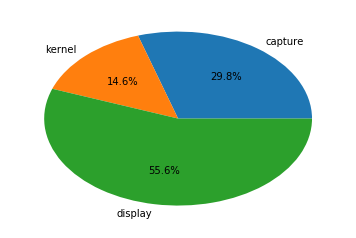

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline
import IPython.display as IPyDis
video = cv2.VideoCapture("video.avi")
display_handle=IPyDis.display(None, display_id=True)
# figure, axis = plt.subplots(figsize=(7.6, 6.1))

counter=0
stTime=time.time()
totleTime=0
kernelTime=0
readTime=0
displayTime=0
try:
    while True:
        readSt=time.time()
        ret, frame = video.read()
        if not ret:
            break
        frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        in_buffer[:] = np.array(frame)
        readTime+=time.time()-readSt
        kernelSt=time.time()
        run_kernel()
        kernelTime+=time.time()-kernelSt
        
        displatSt=time.time()
#         cv2.imshow("output",out_buffer2)
#         cv2.waitKey(10)
#         if counter==0:
#             im = axis.imshow(out_buffer2)
#         else:
#             im.set_data(out_buffer2)
#         plt.show()
#         plt.imshow(out_buffer2)
#         plt.show()
        
        
        resized_image = Image.fromarray(out_buffer2)
        #resized_image.save(f'outputImages/{counter}.jpg')
        
        _, jpg = cv2.imencode('.jpeg', cv2.cvtColor(out_buffer2, cv2.COLOR_RGB2BGR))
        display_handle.update(IPyDis.Image(data=jpg.tobytes()))
#         display_handle.update(resized_image)
        displayTime+=time.time()-displatSt
        
        #print(counter)
        counter+=1
except KeyboardInterrupt:
    pass
finally:
    totleTime=time.time()-stTime
    video.release()
    #cv2.destroyAllWindows()
    display_handle.update(None)
print("avg latency:",totleTime/counter)
print("avg read latency:",readTime/counter)
print("avg kernel latency:",kernelTime/counter)
print("avg display latency:",displayTime/counter)
plt.pie([readTime,kernelTime,displayTime],labels=["capture","kernel","display"],autopct = "%1.1f%%")
plt.show()

In [22]:

del in_buffer
del out_buffer
del out_buffer2